# Prediccion del Valor del Bitcoin

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
#import torch

* Lo primero que se hará sera entrenar un modelo con datos de años anteriores de los valores de BTC y ETH, con el fin de predecir el valor que deberian haber tenido y compararlo con el valor verdadero.
    * El fin de esto es estimar cuanto dinero se perdio calculando el area entre curvas 

In [60]:
df_BTC= pd.read_excel("BTC_Train.xlsx")
date=pd.to_datetime(df_BTC['Date'])
datetime_index = pd.DatetimeIndex(date.values)
df_BTC=df_BTC.set_index(datetime_index).drop(['Date'],axis=1)
df_BTC


,Open,High,Low,Close,Volume,Market Cap
2019-11-01,9193.99,9275.66,9132.05,9261.10,24324691031,166928044164
2019-10-31,9202.46,9383.16,9028.72,9199.58,26583653947,165804227835
2019-10-30,9422.46,9426.87,9085.37,9205.73,27706531577,165899500650
2019-10-29,9248.44,9516.18,9232.65,9427.69,28426779937,169883866262
2019-10-28,9565.10,9805.12,9256.15,9256.15,30948255332,166777392742
...,...,...,...,...,...,...
2015-01-05,265.08,278.34,265.08,274.47,43962800,3758098008
2015-01-04,281.15,287.23,257.61,264.20,55629100,3616320975
2015-01-03,314.85,315.15,281.08,281.08,33054400,3846269872
2015-01-02,314.08,315.84,313.57,315.03,7860650,4309551126


In [63]:
df_ETH= pd.read_excel("ETH_Train.xlsx")
date=pd.to_datetime(df_ETH['Date'])
datetime_index = pd.DatetimeIndex(date.values)
df_ETH=df_ETH.set_index(datetime_index).drop(['Date'],axis=1)
df_ETH

,Open,High,Low,Close,Volume,Market Cap
2019-11-01,183.800000,185.060000,181.090000,183.970000,9145611130,19940014311
2019-10-31,184.800000,188.750000,180.070000,183.970000,9607939606,19937256794
2019-10-30,190.340000,191.110000,181.550000,184.690000,10484902804,20013431227
2019-10-29,182.670000,191.850000,182.360000,190.340000,10622761958,20623205054
2019-10-28,184.400000,187.880000,180.250000,182.660000,10406734124,19788729316
...,...,...,...,...,...,...
2015-08-11,0.708087,1.130000,0.663235,1.070000,1463100,64569288
2015-08-10,0.713989,0.729854,0.636546,0.708448,405283,42818364
2015-08-09,0.706136,0.879810,0.629191,0.701897,532170,42399573
2015-08-08,2.790000,2.800000,0.714725,0.753325,674188,45486894


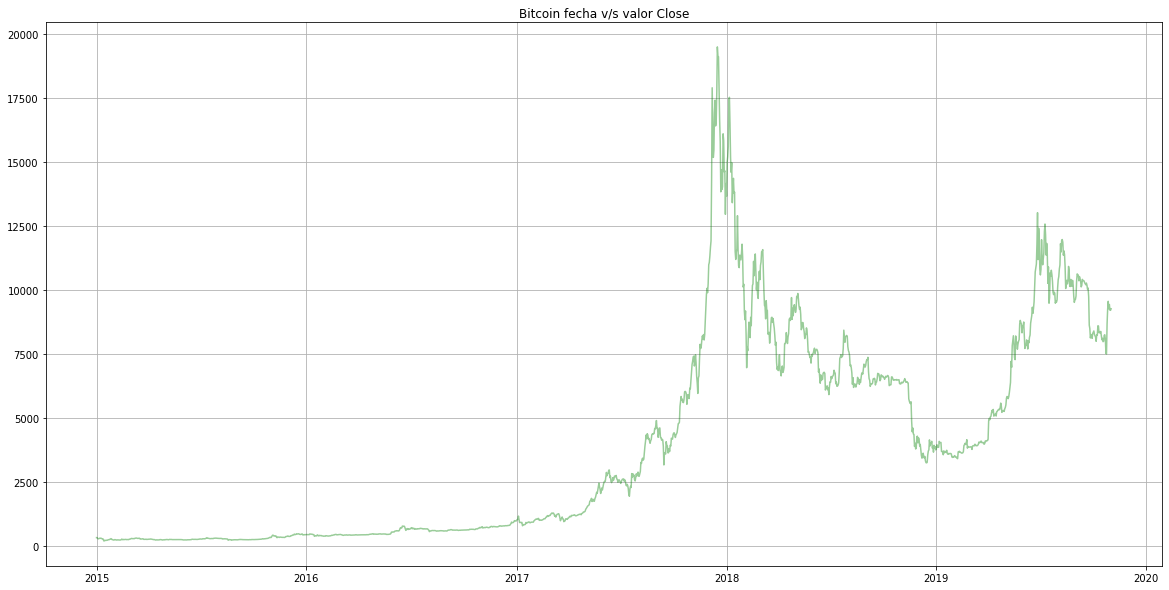

In [71]:
grafico_btc_close=plt.figure(figsize=(20,10))
plt.grid(True)
plt.title('Bitcoin fecha v/s valor Close')
plt.plot(df_BTC.index,df_BTC['Close'],c='g',alpha=0.4)

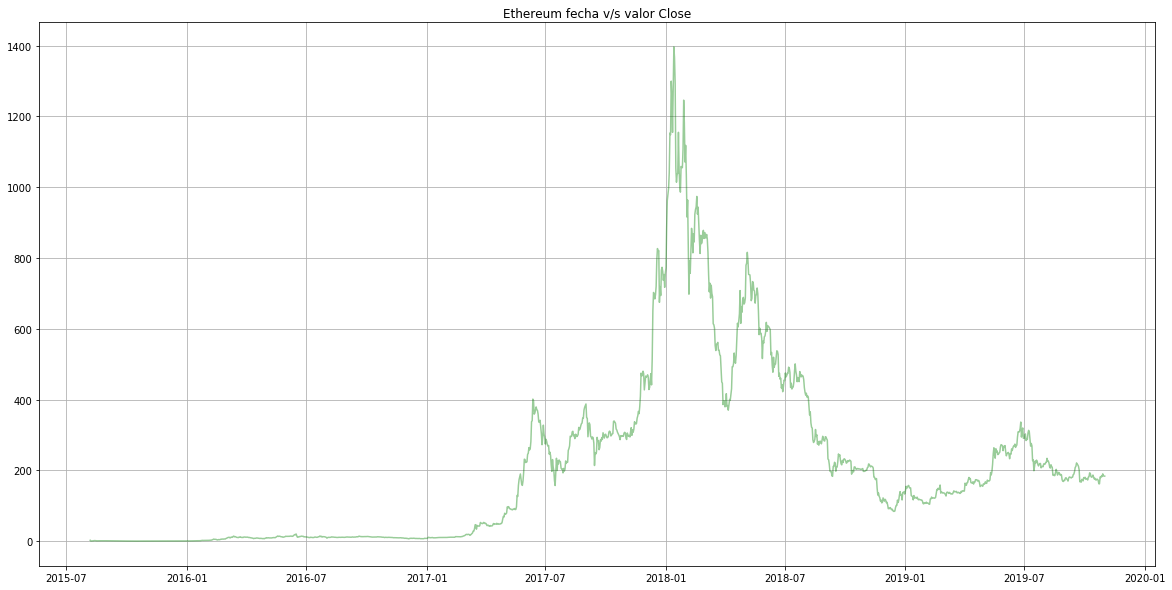

In [70]:
grafico_eth_close=plt.figure(figsize=(20,10))
plt.grid(True)
plt.title('Ethereum fecha v/s valor Close')
plt.plot(df_ETH.index,df_ETH['Close'],c='g',alpha=0.4)


In [76]:
from sklearn.preprocessing import StandardScaler

df_btc_train=df_BTC["Close"]

scaler = StandardScaler()
train_arr = scaler.fit_transform(df_btc_train)
#val_arr = scaler.transform(df_val)
#test_arr = scaler.transform(df_test)




dtype('float64')